# Including clouds

## Powerlaw cloud models

Let's initialize an atmosphere in the usual way, see ["Getting Started"](getting_started.html):

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from petitRADTRANS.radtrans import Radtrans
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.physics import temperature_profile_function_guillot_global

atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250m

/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'temps.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'CIA_H2-H2_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'CIA_H2-He_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "


<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive), and the mean molecular mass in atomic mass units. They will be converted to cgs units within the code.
</div>

Next we set up the atmospheric parameters, with a parameter selection identical to the ["Getting Started"](getting_started.html) case.

In [2]:
planet_radius = 1.0*cst.r_jup_mean
reference_gravity = 10**3.5
reference_pressure = 0.01

pressures_bar = atmosphere.pressures*1e-6 # cgs to bar
kappa_IR = 0.01
gamma = 0.4
T_int = 200.
T_equ = 1500.
temperatures = temperature_profile_function_guillot_global(pressures_bar, kappa_IR, gamma, reference_gravity, T_int, T_equ)

mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 0.01 * np.ones_like(temperatures)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperatures)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperatures)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperatures)
mass_fractions['K'] = 0.000001 * np.ones_like(temperatures)

mean_molar_masses = 2.33 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** remember that abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the mass of a single molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

Now, let's calculate cloudy spectra! The first available mode is the so-called power law cloud. In this case the following opacity is *added* to the scattering cross-section:
\begin{equation}
\kappa = \kappa_0\left(\frac{\lambda}{\lambda_0}\right)^\gamma
\end{equation}
Where $\kappa_0$ is the opacity in units of cm$^2$/g, at $\lambda_0=0.35 \ {\rm \mu m}$. The power law index $\gamma$ fixes the wavelength dependence, Rayleigh-like scattering would be obtained for $\gamma=-4$. Hence $\kappa_0$ and $\gamma$ are free parameters.

We now calculate a clear atmosphere, and then four power law cloudy models, with $\kappa_0 = 0.01$ cm$^2$/g, and four different $\gamma$ values.

Clear model:

In [3]:
# Clear
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)
clear = transit_radii/cst.r_jup_mean

First, $\gamma = -4$ (Rayleigh-like):

In [4]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = -4.

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   power_law_opacity_350nm=power_law_opacity_350nm,
                                                                   power_law_opacity_coefficient=power_law_opacity_coefficient)

m4 = transit_radii/cst.r_jup_mean

Second, $\gamma = -2$ (weaker scattering power law):

In [5]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = -2.

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   power_law_opacity_350nm=power_law_opacity_350nm,
                                                                   power_law_opacity_coefficient=power_law_opacity_coefficient)

m2 = transit_radii/cst.r_jup_mean

Third, $\gamma = 0$ (flat opacity):

In [6]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = 0.

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   power_law_opacity_350nm=power_law_opacity_350nm,
                                                                   power_law_opacity_coefficient=power_law_opacity_coefficient)

m0 = transit_radii/cst.r_jup_mean

Fourth, the exoctic case of, $\gamma = 1$ (positive opacity slope):

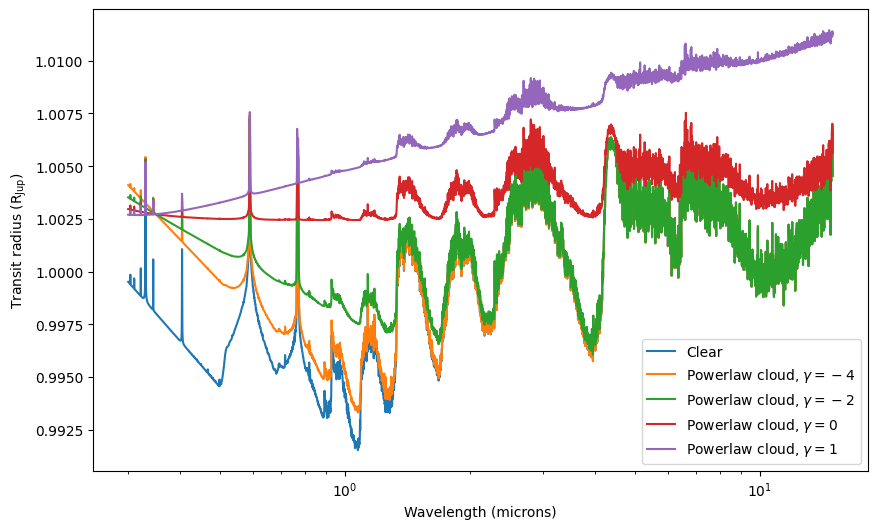

In [7]:
power_law_opacity_350nm = 0.01
power_law_opacity_coefficient = 1.

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   power_law_opacity_350nm=power_law_opacity_350nm,
                                                                   power_law_opacity_coefficient=power_law_opacity_coefficient)

p1 = transit_radii/cst.r_jup_mean

# Make plot

fig, ax = plt.subplots(figsize = (10,6))

ax.plot(wavelengths*1e4, clear, label = 'Clear')

ax.plot(wavelengths*1e4,
        m4,
        label = r'Powerlaw cloud, $\gamma = -4$')

ax.plot(wavelengths*1e4,
        m2,
        label = r'Powerlaw cloud, $\gamma = -2$')

ax.plot(wavelengths*1e4,
        m0,
        label = r'Powerlaw cloud, $\gamma = 0$')

ax.plot(wavelengths*1e4,
        p1,
        label = r'Powerlaw cloud, $\gamma = 1$')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc = 'best')
plt.show()

## Gray cloud deck and/or scaled Rayhleigh scattering

In addition to power law clouds, petitRADTRANS can also simply add a gray cloud deck, or scale the Rayleigh scattering opacities of the gas by a factor specified by the user. For these examples we will reuse the Radtrans object from the demonstration of the power law cloud above, there's no need to intialize it again.

Let's calculate three spectra:
-  A clear model
-  A cloudy model with a gray cloud deck at 0.01 bar
-  A haze-like model, mimicked by scaling the Rayleigh scattering of the gas by a factor 10
-  A combination of the two above cloud models: gray cloud deck plus haze

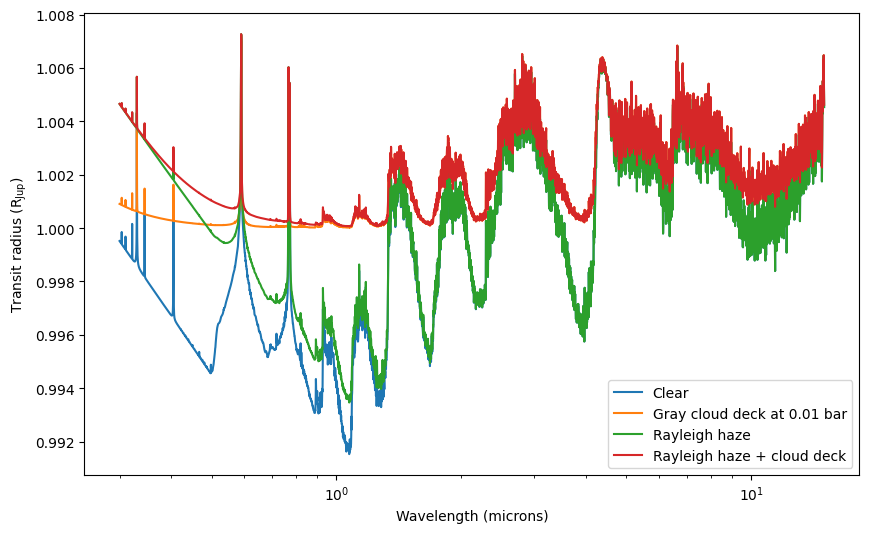

In [8]:
fig, ax = plt.subplots(figsize = (10,6))

# Clear
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = 'Clear')

# Gray cloud deck at 0.01 bar
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   opaque_cloud_top_pressure = 0.01)

ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = 'Gray cloud deck at 0.01 bar')

# Haze (10 x gas Rayleigh scattering)
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   haze_factor = 10.)

ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = 'Rayleigh haze')

# Haze + cloud deck
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   opaque_cloud_top_pressure = 0.01,
                                                                   haze_factor = 10.)
ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = 'Rayleigh haze + cloud deck')

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc = 'best')
plt.show()

## Defining arbitrary opacity functions (can be used to parameterize clouds)

What happens if you have a favorite cloud parameterization, but its implementation is not offered in pRT? Fear not, there is an option for you! When running `calculate_transit_radii()` (or `calculate_flux()`) you can hand it any arbitrary function that returns a scattering or absorption opacity as a function of wavelength and pressure to pRT. This is then going to be used in that particular `calculate_transit_radii()` or `calculate_flux()` run. An example can be found below, where we implement the following cloud model:
\begin{equation}
\kappa_{\rm cloud}(\lambda, P)= \frac{\kappa_0}{1+\left(\lambda/\lambda_0\right)^p} \left(\frac{P}{P_{\rm base}}\right)^{f_{\rm sed}} {\rm \ if \ } P<P_{\rm base}
\end{equation}
and $0$ if $P\geq P_{\rm base}$. Here, $\lambda$ and $P$ are the wavelength in micron and pressure in bar, respectively, and $\kappa_0$, $\lambda_0$, $p$, $P_{\rm base}$ and $f_{\rm sed}$ are free parameters, thought to parameterize the opacity (in $\rm cm^2/g$) at the reference wavelength $\lambda_0$, the power law dependence of the opacity with wavelengh at $\lambda \gg \lambda_0$, the cloud base pressure in bar, and the cloud scale height descrease factor, respectively.

Here an example implementation of this cloud model:

In [9]:
def cloud_opas(kappa_0,
               lambda_0,
               p,
               P_base,
               f_sed):
                     # in micron, in bar
    def give_opacity(wlen, press):
        
        retVal = np.zeros((len(wlen), len(press)))
        
        for i_p in range(len(press)):
            if press[i_p] < P_base:
                retVal[:, i_p] = kappa_0 / (1. + (wlen/lambda_0)**p) * (press[i_p]/P_base)**f_sed
            else:
                retVal[:, i_p] = 0.
        return retVal
        
    return give_opacity

We can now hand this function to `calculate_transit_radii()` or (`calculate_flux()`). If we want to use it as an absorption opacity, we have to use the `additional_absorption_opacities_function` keyword. If we want to use it as a scattering opacity, we have to use the `additional_scattering_opacities_function` keyword. Note that in the transmission spectrum case the results will not differ between the two options, because both scattering and absorption cross-sections simply contribute to the total extinction opacity.

Below some examples:

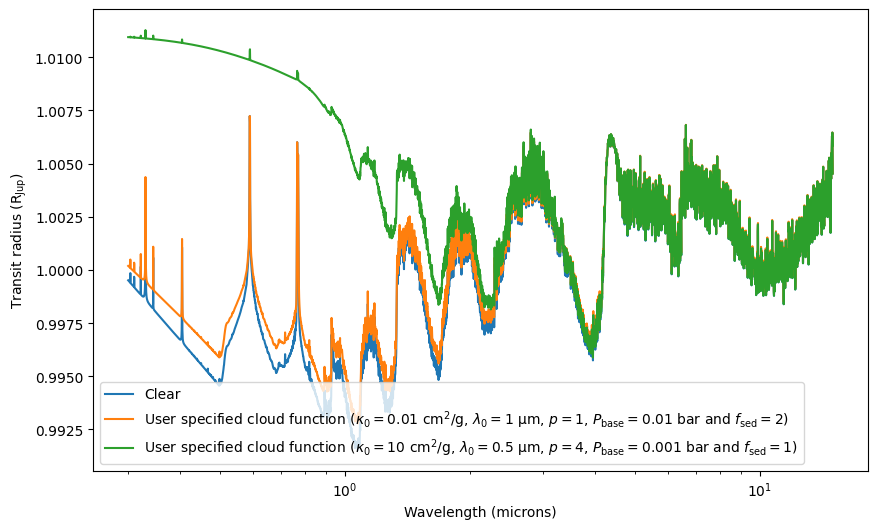

In [10]:
fig, ax = plt.subplots(figsize = (10,6))

# Clear
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure)

ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = 'Clear')

# External cloud absorption function, test 1
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   additional_absorption_opacities_function=\
                                                                      cloud_opas(1e-2, 1., 1., 0.01, 2))

ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = r'User specified cloud function ' \
                   r'$(\kappa_0=0.01 \ {\rm cm^2/g}$, $\lambda_0=1 \ {\rm \mu m}$, $p=1$, ' \
                   r'$P_{\rm base} = 0.01  \ {\rm bar}$ and $f_{\rm sed}=2$)')

# External cloud absorption function, test 2
wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   additional_absorption_opacities_function=\
                                                                      cloud_opas(1e1, 0.5, 4, 0.001, 1))
ax.plot(wavelengths*1e4,
         transit_radii/cst.r_jup_mean,
         label = r'User specified cloud function ' \
                   r'$(\kappa_0=10 \ {\rm cm^2/g}$, $\lambda_0=0.5 \ {\rm \mu m}$, $p=4$, ' \
                   r'$P_{\rm base} = 0.001  \ {\rm bar}$ and $f_{\rm sed}=1$)')


ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
plt.legend(loc = 'best')
plt.show()

<div class="alert alert-warning">

**If you use this option in correlated-k (`c-k`) mode, please only parameterize opacities that vary slowly enough with wavelength. Molecular and atomic line opacities must not be added in this way, for example, for these the correlated-k opacity treatment is required. Clouds (even if they have an absorption feature) and other pseudo-continuum opacities such as collision induced absorption (CIA) could be handled well with the treatment above, however.**
</div>

## Condensate clouds from real optical constants

Let's calculate some spectra using opacities derived from optical constants of various materials.
In this example we will take forsterite, that is, $\rm Mg_2SiO_4$. For the list of available cloud species see ["Available opacity species"](../available_opacities.html).

<div class="alert alert-info">

**Choose your favorite particle setup:** petitRADTRANS offers multiple opacity versions for every given condensate, assuming either spherical (Mie scattering) or irreagularly shaped (DHS method = distribution of hollow spheres) particles. Moreover, opacities assuming a crystalline and/or amorphous internal structure can be used, where available.

</div>

We set up the atmosphere like before, this time loading the opacity of solid (``s``), ``crystalline``, irregularly shaped particles (``DHS`` method). The mode identifier for the $\rm Mg_2SiO_4$ opacity therefore is ``Mg2SiO4(s)_crystalline__DHS``. Note that for some species only crystalline or amorphous cross-sections are available.

But now, let's start! We simply give one additional ``cloud_species`` list to the Radtrans object, containing the name of the opacity species we want to use.

In [11]:
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      cloud_species = ['Mg2SiO4(s)_crystalline__DHS'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250m

<div class="alert alert-warning">

**Units in petitRADTRANS:** remember that all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

Next we will setup the amtosphere, with a parameter selection *almost* identical to the ["Getting Started"](getting_started.html) case. We also add the mass fraction of the cloud species we are interested in now.

In [20]:
mass_fractions = {}
mass_fractions['H2'] = 0.74 * np.ones_like(temperatures)
mass_fractions['He'] = 0.24 * np.ones_like(temperatures)
mass_fractions['H2O'] = 0.001 * np.ones_like(temperatures)
mass_fractions['CO-NatAbund'] = 0.01 * np.ones_like(temperatures)
mass_fractions['CO2'] = 0.00001 * np.ones_like(temperatures)
mass_fractions['CH4'] = 0.000001 * np.ones_like(temperatures)
mass_fractions['Na'] = 0.00001 * np.ones_like(temperatures)
mass_fractions['K'] = 0.000001 * np.ones_like(temperatures)
mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 0.0000005 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** remember that abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

### Setting the cloud particle size

We have to define a few additional parameters for the clouds, to start the calculation. Since we here assume a log-normal paricle size distribution, we give the mean particle size and width of the distribution:

In [21]:
cloud_particles_mean_radii = {}
cloud_particles_mean_radii['Mg2SiO4(s)_crystalline__DHS'] = 0.00005*np.ones_like(temperatures)
                                                             # I.e. a 0.5-micron particle size (0.00005 cm)

cloud_particle_radius_distribution_std = 1.05
# a value of 1.0 would be a delta function, so we assume a very narrow distribtion here.

Now, let's calculate a clear and cloudy spectrum to compare:

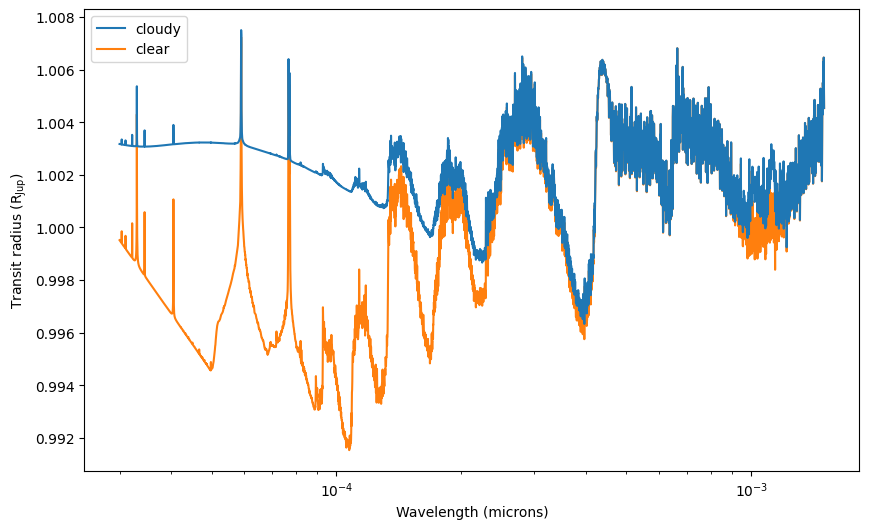

In [22]:
fig, ax = plt.subplots(figsize = (10,6))

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   cloud_particles_mean_radii=cloud_particles_mean_radii,
                                                                   cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std)

ax.plot(wavelengths, transit_radii/cst.r_jup_mean, label = 'cloudy', zorder = 2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   cloud_particles_mean_radii=cloud_particles_mean_radii,
                                                                   cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std)

ax.plot(wavelengths, transit_radii/cst.r_jup_mean, label = 'clear', zorder = 1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')
plt.show()

Here one sees that there is a lot of additional absorption in the optical and near-IR. Also note the silicate (Si-O stretching mode) becoming visible at 10 micron.

### Calculating the particle size

In [54]:
atmosphere = Radtrans(pressures = np.logspace(-6,2,100),
                      line_species = ['H2O', 
                                      'CO-NatAbund', 
                                      'CH4', 
                                      'CO2', 
                                      'Na',
                                      'K'],
                      rayleigh_species = ['H2', 'He'],
                      gas_continuum_contributors = ['H2-H2', 'H2-He'],
                      cloud_species = ['Mg2SiO4(s)_crystalline__DHS',
                                      'Fe(s)_amorphous__Mie'],
                      wavelength_boundaries = [0.3, 15])

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na' from file '/Volumes/USB256/input_data_v3/opacities/lines/correlated_k/Na/23Na/23Na__Allard.R1000_0.1-250m

/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'temps.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'CIA_H2-H2_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "
/Users/molliere/Documents/Project_Docs/petitRADTRANS/petitRADTRANS/_input_data_loader.py:212: UserWarning: file 'CIA_H2-He_final.dat' lack spectral information (resolution: , range: )
  warnings.warn(f"file '{file}' lack spectral information "


Alternatively, one can specify an eddy diffusion parameter ($K_{zz}$, with units of cm$^2$/s), which expresses how strong atmospheric mixing is. The cloud particle size is then controlled by specifying $K_{zz}$, and the unitless settling parameter $f_{\rm sed}$, which expresses the particles' mass averaged settling velocity, when compared to the local atmospheric mixing speed. Also, a width for the log-normal particle size distribution must be specified:

In [58]:
eddy_diffusion_coefficient = np.ones_like(temperatures)*1e1**7.5
cloud_f_sed = 2 #{}
#cloud_f_sed['Mg2SiO4(s)_crystalline__DHS'] = 2.
#cloud_f_sed['MFe(s)_amorphous__Mie'] = 2.
cloud_particle_radius_distribution_std = 1.05

Again, let's calculate a clear and cloudy spectrum to compare:

ValueError: unexpected array size: new_size=2, got array with arr_size=1


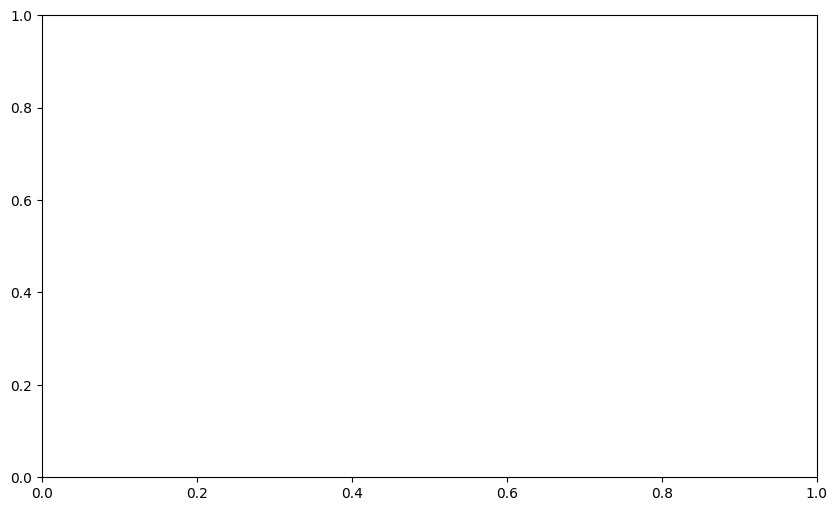

In [59]:
fig, ax = plt.subplots(figsize = (10,6))

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = 0.0000005 * np.ones_like(temperatures)
mass_fractions['MFe(s)_amorphous__Mie'] = 0.0000005 * np.ones_like(temperatures)

wavelengths, transit_radii, additional_output = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   eddy_diffusion_coefficient=eddy_diffusion_coefficient,
                                                                   cloud_f_sed=cloud_f_sed,
                                                                   cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std)

ax.plot(wavelengths, transit_radii/cst.r_jup_mean, label = 'cloudy', zorder = 2)

mass_fractions['Mg2SiO4(s)_crystalline__DHS'] = np.zeros_like(temperatures)
mass_fractions['MFe(s)_amorphous__Mie'] = np.zeros_like(temperatures)

wavelengths, transit_radii, _ = atmosphere.calculate_transit_radii(temperatures=temperatures, 
                                                                   mass_fractions=mass_fractions, 
                                                                   mean_molar_masses=mean_molar_masses, 
                                                                   reference_gravity=reference_gravity, 
                                                                   planet_radius=planet_radius, 
                                                                   reference_pressure=reference_pressure,
                                                                   eddy_diffusion_coefficient=eddy_diffusion_coefficient,
                                                                   cloud_f_sed=cloud_f_sed,
                                                                   cloud_particle_radius_distribution_std = cloud_particle_radius_distribution_std)

ax.plot(wavelengths, transit_radii/cst.r_jup_mean, label = 'clear', zorder = 1)

ax.set_xscale('log')
ax.set_xlabel('Wavelength (microns)')
ax.set_ylabel(r'Transit radius ($\rm R_{Jup}$)')
ax.legend(loc='best')
plt.show()

The resulting mean particle sizes can be accessed like this:

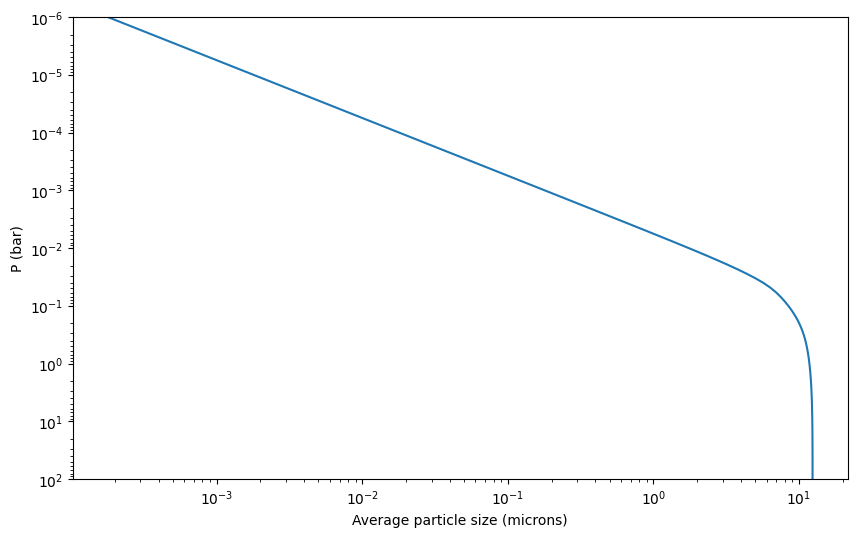

In [51]:
fig, ax = plt.subplots(figsize = (10,6))

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim([1e2,1e-6])

ax.set_ylabel('P (bar)')
ax.set_xlabel('Average particle size (microns)')

#print(np.shape(additional_output[0]))
#print(np.shape(additional_output['cloud_particles_mean_radii']))

ax.plot(additional_output['cloud_particles_mean_radii'][:,0]/1e-4, atmosphere.pressures/1e6)
plt.show()
#plt.clf()

# ADD SECOND SPECIES!

## Hansen Distribution Clouds

While the Ackermann-Marley model used here typically uses a log-normal distribution for the cloud particle radii, it is also possible to use the [Hansen+ (1971)](http://web.gps.caltech.edu/~vijay/Papers/Polarisation/hansen-71b.pdf) distribution. To do this, you'll need to set the `dist` parameter in `calc_flux` to `hansen`, and set the effective width of the distribution with the `b_hans` parameter. Alternately, you can specify both the distribution width and center using the `b_hans` and `a_hans` arguments. Note that the value of `b_hans` will be different from that of `sigma_lnorm` to give a similar distribution, as the effective width is weighted by the particle area. See the Hansen+ (1971) paper for more details.

Here, we'll calculate the mean particle size as a function of altitude

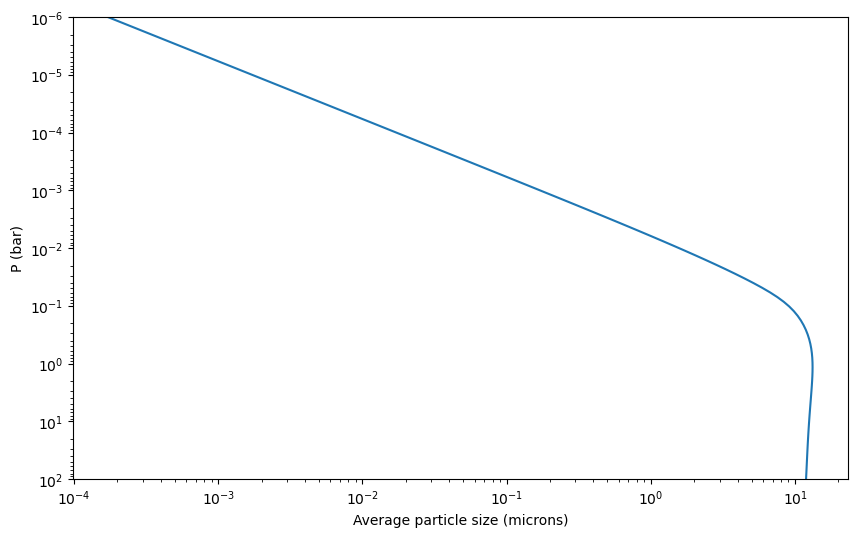

<Figure size 1000x600 with 0 Axes>

In [33]:
mass_fractions['Mg2SiO4(c)'] = 0.0000005 * np.ones_like(temperature)
Kzz = np.ones_like(temperature)*1e1**7.5
fsed = 2.
b_hans = 0.01
atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, 
                       Kzz = Kzz, fsed=fsed, b_hans=b_hans,dist='hansen')

plt.yscale('log')
plt.xscale('log')

plt.ylim([1e2,1e-6])

plt.ylabel('P (bar)')
plt.xlabel('Average particle size (microns)')

plt.plot(atmosphere.r_g[:,atmosphere.cloud_species.index('Mg2SiO4(c)')]/1e-4, pressures)
plt.show()
plt.clf()

<div class="alert alert-warning">

**Minimum particle size:** the opacity of particles smaller than 1 nm is set to zero.

</div>

## Emission spectra

We can use the Radtrans object created above to calculate emission spectra as well. Here we will also generate an instance of pRT with scattering turned on with ``do_scat_emis = True``, (see ["Scattering for Emission Spectra"](emis_scat.html) for an example on how to do this in detail).

Emission scattering is enabled: enforcing test_ck_shuffle_comp = True
  Read line opacities of H2O_HITEMP...
 Done.
  Read line opacities of CO_all_iso_HITEMP...
 Done.
  Read line opacities of CH4...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of Na_allard...
 Done.
  Read line opacities of K_allard...
 Done.

  Read in opacity of cloud species Mg2SiO4 ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



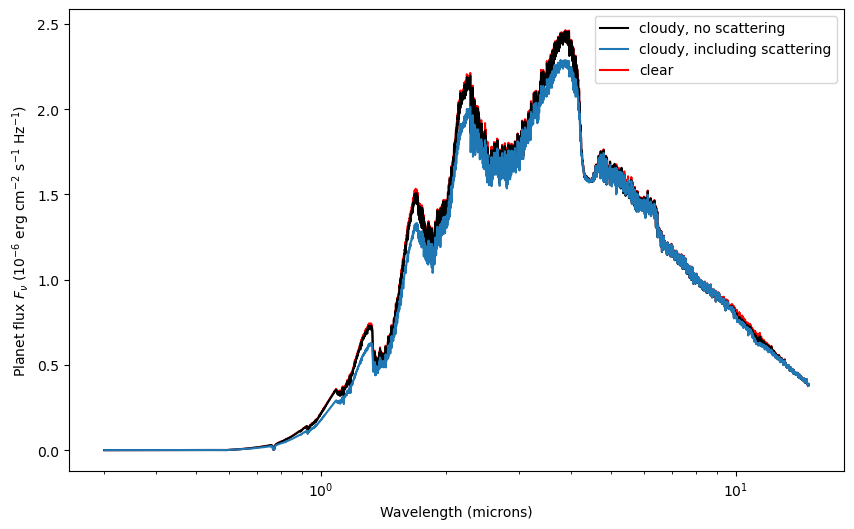

<Figure size 1000x600 with 0 Axes>

In [34]:
mass_fractions['Mg2SiO4(c)'] = 0.0000005 * np.ones_like(temperature)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm)

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         color = 'black', label = 'cloudy, no scattering', zorder = 1)

# Load scattering version of pRT
atmosphere = Radtrans(line_species = ['H2O_HITEMP',
                                      'CO_all_iso_HITEMP',
                                      'CH4',
                                      'CO2',
                                      'Na_allard',
                                      'K_allard'], \
      cloud_species = ['Mg2SiO4(c)_cd'], \
      rayleigh_species = ['H2', 'He'], \
      continuum_opacities = ['H2-H2', 'H2-He'], \
      wlen_bords_micron = [0.3, 15], \
      do_scat_emis = True)

pressures = np.logspace(-6, 2, 100)
atmosphere.setup_opa_structure(pressures)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm, \
                       add_cloud_scat_as_abs = True)
plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, \
         label = 'cloudy, including scattering', zorder = 2)

mass_fractions['Mg2SiO4(c)'] = np.zeros_like(temperature)

atmosphere.calc_flux(temperature, mass_fractions, gravity, MMW, \
                       Kzz = Kzz, fsed=fsed, sigma_lnorm = sigma_lnorm)

plt.plot(nc.c/atmosphere.freq/1e-4, atmosphere.flux/1e-6, '-', \
         color = 'red', label = 'clear', zorder = 0)

plt.legend(loc='best')
plt.xscale('log')
plt.xlabel('Wavelength (microns)')
plt.ylabel(r'Planet flux $F_\nu$ (10$^{-6}$ erg cm$^{-2}$ s$^{-1}$ Hz$^{-1}$)')
plt.show()
plt.clf()

Here we plotted the clear spectrum, neglecting the cloud opacity, the cloudy spectrum only considering the absorption of the cloud particles, and the cloudy spectrum with scattering, using the scattering version of pRT.

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](emis_scat.html) for an example how to do this).
</div>